## 3. Horse Race Record Descriptive Analysis

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns

from tslearn.clustering import GlobalAlignmentKernelKMeans, TimeSeriesKMeans
from tslearn.metrics import sigma_gak

def parse_rank_info(rank):
    # Parse rank information
    try:
        return re.search(r'\d+', rank).group(0)
    except AttributeError:
        return np.nan

# Set some specs for plotting
%matplotlib inline
mpl.rcParams['figure.figsize'] = (16.0, 8.0)
mpl.style.use('ggplot')
plt.rcParams['font.family'] = 'IPAGothic'

# Read data from the data folder
race_df = pd.read_csv('data/race.csv', low_memory=False, index_col=0)
horse_df = pd.read_csv('data/horse.csv', low_memory=False, index_col=0)
horse_race_df = pd.read_csv('data/horse_race.csv', low_memory=False, index_col=0)

# Further preprocessing
horse_race_df['finishing_position'] = horse_race_df['finishing_position'].apply(lambda x: parse_rank_info(x))
horse_race_df = horse_race_df.dropna(subset=['finishing_position'])
horse_race_df['finishing_position'] = horse_race_df['finishing_position'].astype(int)
horse_race_df['age_int'] = horse_race_df['sex_age'].apply(lambda x: re.search(r'\d+', x).group(0)).astype(int)

## 3.1 Horse Age and Speed

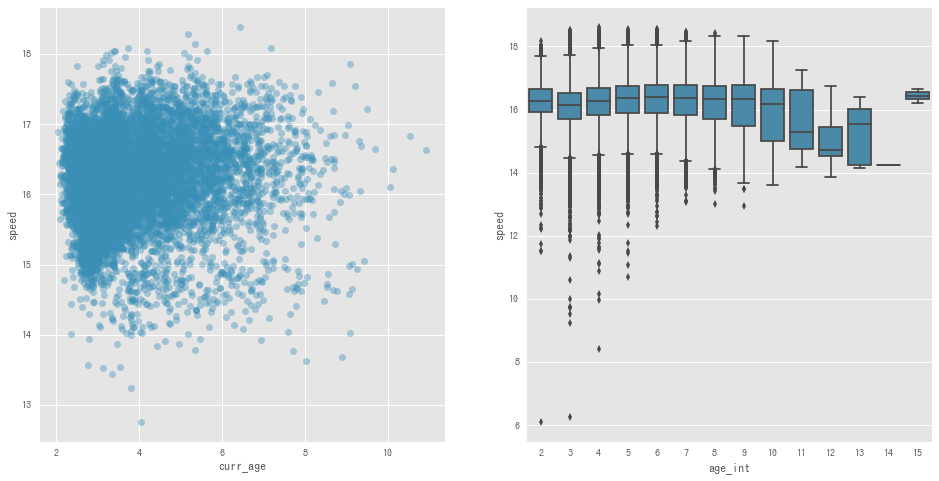

In [2]:
fig, ax = plt.subplots(1, 2)
time_age = horse_race_df.loc[:, ['horse_id', 'run_time', 'distance', 'curr_age', 'age_int']]
time_age['speed'] = time_age['distance'] / time_age['run_time']
sns.regplot(x='curr_age', y='speed', data=time_age.sample(n=10000), fit_reg=False, 
            color='#3A8FB7', ax=ax[0], scatter_kws={'alpha': .4})
sns.boxplot(x='age_int', y='speed', data=time_age, color='#3A8FB7', ax=ax[1])

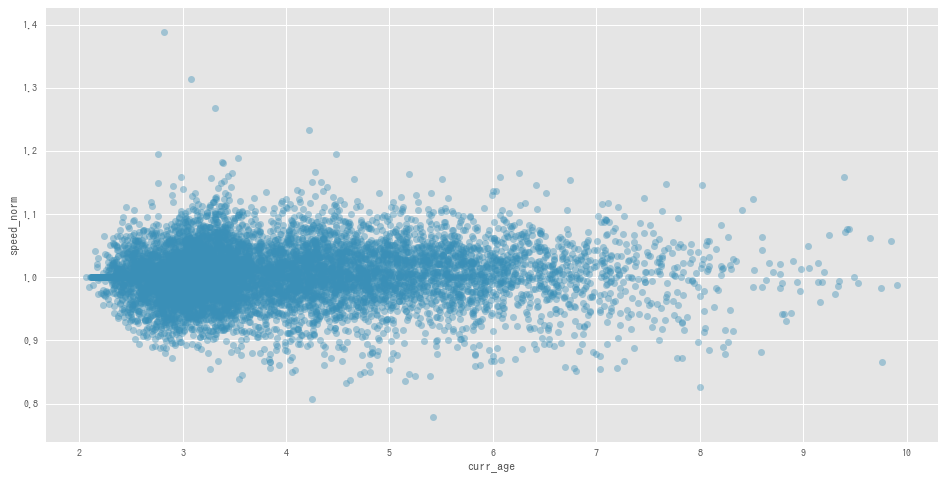

In [3]:
time_age = time_age.sort_values(['horse_id', 'curr_age'])
time_age['speed'] = time_age['speed'].astype(str)
time_age['curr_age'] = time_age['curr_age'].astype(str)
speed_perf = time_age.groupby('horse_id').agg({'curr_age': lambda x: ', '.join(x), 'speed': lambda x: ', '.join(x)})
speed_perf = speed_perf.applymap(lambda x: list(map(lambda y: float(y), x.split(', '))))
speed_perf['speed'] = speed_perf['speed'].apply(lambda x: list(map(lambda y: (y - x[0]) / x[0] + 1, x)))
speed = speed_perf['speed'].apply(pd.Series).stack().reset_index().set_index('horse_id')[0]
time_age['speed_norm'] = pd.Series(list(speed), index=time_age.index)
time_age['curr_age'] = time_age['curr_age'].astype(float)
time_age['speed_norm']  = time_age['speed_norm'].astype(float)
sns.regplot(x='curr_age', y='speed_norm', data=time_age.sample(n=10000), fit_reg=False, color='#3A8FB7', scatter_kws={'alpha': .4})

## 3.2 Time Series Analysis and Clustering

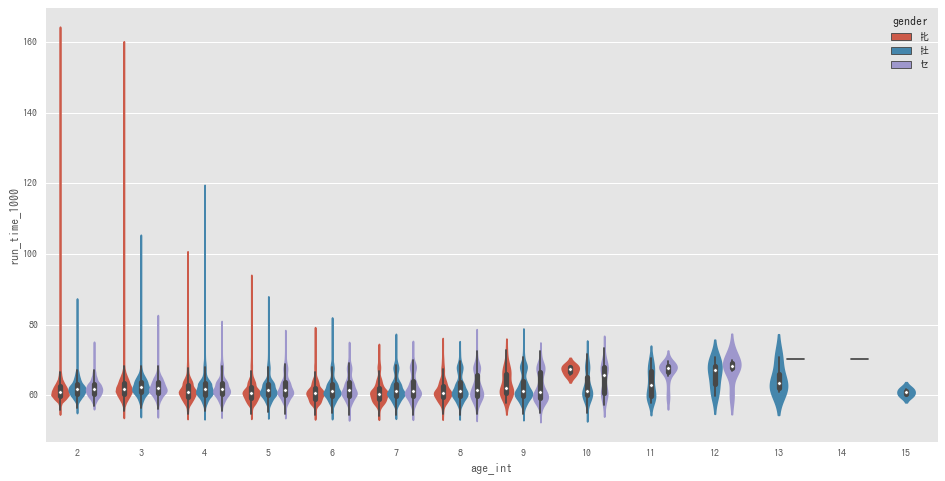

In [4]:
sns.violinplot(x='age_int', y='run_time_1000', hue='gender', data=horse_race_df)

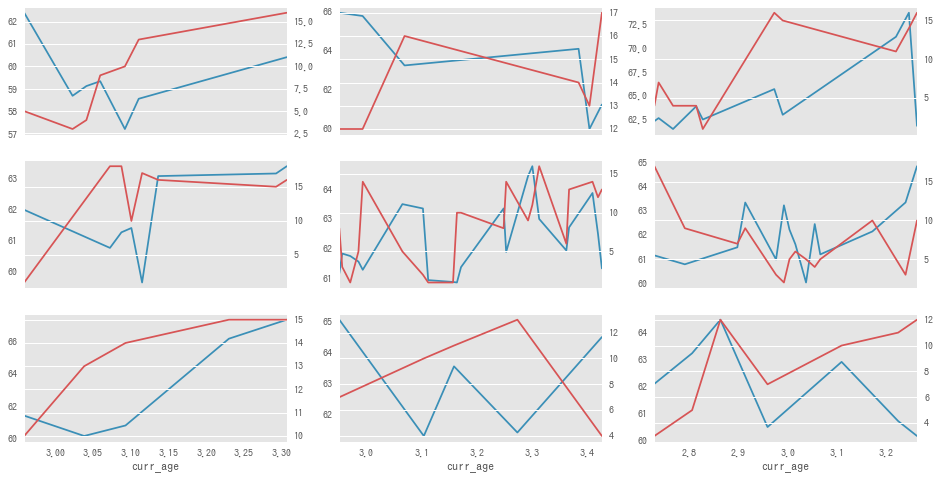

In [5]:
# Randomly choose horses to plot
id_count = horse_race_df['horse_id'].value_counts()
id_count = id_count[id_count > 1]
plot_num = 3
fig, ax = plt.subplots(plot_num, plot_num)
for i_idx in range(plot_num):
    for j_idx in range(plot_num):
        random_index = id_count.sample(n=1).index
        random_horse_record = horse_race_df.loc[horse_race_df['horse_id'].isin(random_index)]
        '''
            Blue: Run time
            Red: Finishing position (rank)
        '''
        random_horse_record.sort_values('curr_age').plot(x='curr_age', y='run_time_1000', 
                                                         color='#3A8FB7', ax=ax[i_idx][j_idx], 
                                                         legend=None)
        random_horse_record.sort_values('curr_age').plot(x='curr_age', y='finishing_position', 
                                                         color='#D75455', ax=ax[i_idx][j_idx], 
                                                         legend=None, secondary_y=True)

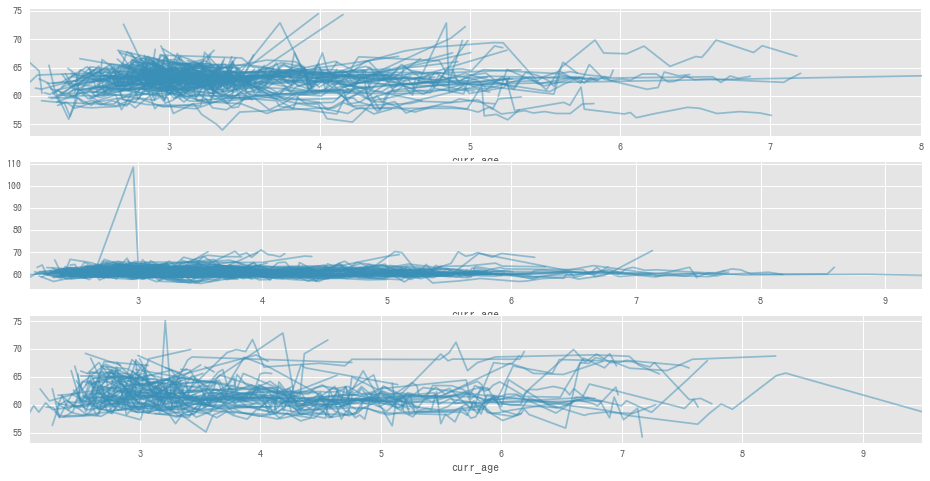

In [6]:
sample_horse = horse_race_df['horse_id'].value_counts().sample(n=500).index
sample_data = horse_race_df.loc[horse_race_df['horse_id'].isin(sample_horse), ['horse_id', 'run_time_1000', 'curr_age']]
sample_data = sample_data.sort_values(['horse_id', 'curr_age'])
sample_data['run_time_1000'] = sample_data['run_time_1000'].astype(str)
final = sample_data.groupby('horse_id')['run_time_1000']
final = final.apply(lambda x:np.array(list(map(lambda x: float(x), ', '.join(x).split(', ')))))
train = np.array(final)

num_cluster = 3
gak_km = GlobalAlignmentKernelKMeans(n_clusters=num_cluster, n_init=20, verbose=False, sigma=sigma_gak(train))
pred = gak_km.fit_predict(train)
sample_data = sample_data.merge(pd.DataFrame(pd.Series(pred, index=final.index, name='Cluster')).reset_index(), on='horse_id')

sample_data['curr_age'] = sample_data['curr_age'].astype(float)
sample_data['run_time_1000'] = sample_data['run_time_1000'].astype(float)

fig, ax = plt.subplots(num_cluster, 1)

for cluster in range(num_cluster):
    data = sample_data.loc[sample_data['Cluster'] == cluster]
    for horse_id in data.horse_id.value_counts().index:
        data.loc[data['horse_id'] == horse_id].plot(x='curr_age', y='run_time_1000', 
                                                    ax=ax[cluster], legend=None, color='#3A8FB7', alpha=.5)